# Lasso on the IBLI dataset

In this notebook, I will be using a Lasso Cross Validation model, and a Group Lasso model on the IBLI dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import os
import seaborn as sns
from scipy.stats import f_oneway

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error, r2_score


# Load and preprocess the data

In [2]:
#Load in the dataset
df = pd.read_excel("C:/Users/daanm/Documents/Universiteit Utrecht/Scriptie/cattle_df.xlsx")
df.head()

,Unnamed: 0,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,eng_language,expend,...,main_info_source_recoded,religion_recoded,owns_phone,household_moved,purchase_bin,why_not_purchase_recoded,know_vip,trust_vip,advise_vip,ratio_insured_cattle
0,0,1,4,No,25,Yes,No,Never attended,No,0,...,Interpersonal Sources,Traditional/Wakefata,0,No,No,Lack of Awareness or Understanding,Yes,Yes,Yes,0.0
1,1,2,4,Yes,27,Yes,No,Adult Education,No,0,...,Interpersonal Sources,Traditional/Wakefata,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes,0.0
2,2,3,4,Yes,29,No,No,Elementary,No,1,...,Professional and Organizational Sources,Christian,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes,0.0
3,3,4,4,No,35,Yes,No,Never attended,No,0,...,Interpersonal Sources,Traditional/Wakefata,0,No,No,"Financial, Practical, and Situational Constraints",Yes,Yes,Yes,0.0
4,5,6,4,No,60,Yes,No,Never attended,No,0,...,Interpersonal Sources,Traditional/Wakefata,0,No,No,Lack of Awareness or Understanding,Yes,Yes,No,0.0


In [31]:
#Agreement has been made to drop the ratio column from this dataset since it introduces endogeneity

df = df.drop(['cs_cs_ratio_post_cattle'], axis=1)
columns_list = df.columns.tolist()
print(columns_list)

KeyError: "['cs_cs_ratio_post_cattle'] not found in axis"

In [4]:
#Log+1 transforming the dataset to get a better distribution

df['cs_diff_log'] = np.log(np.abs(df['cs_cs_diff_post_cattle']) + 1)
df[['cs_cs_diff_post_cattle', 'cs_diff_log']].head()

,cs_cs_diff_post_cattle,cs_diff_log
0,-188.170624,5.242649
1,-850.367249,6.746844
2,-5219.686523,8.560384
3,-157.544266,5.066034
4,-158.881271,5.074431


# Deploying the Lasso Model
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

In [5]:
y = df['cs_diff_log']
X = df.drop(columns=['cs_diff_log', 'cs_cs_diff_post_cattle'])

In [6]:
categorical = X.select_dtypes(include=['object','category']).columns.tolist()
numerical = X.select_dtypes(include=['int64','float64']).columns.tolist()

In [7]:
#Preprocess the pipeline
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numerical),
    
#Encode the categorical columns    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical)
])


In [8]:
#Create a Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', LassoCV(cv=5, random_state=42))
])

lasso_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Unnamed: 0', 'id', 'wave',
                                                   'age_constant', 'expend',
                                                   'irrigated_land_bin',
                                                   'buy_nr_cattle',
                                                   'n_previd_cattle',
                                                   'number_minors',
                                                   'number_adults',
                                                   'owns_phone',
                                                   'ratio_insured_cattle']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute...
                                                  ['afm_language', 'agric_land',
                                                   'amh_language',
                                                   'educ_recoded_constant',
                                                   'eng_language', 'buy_cattle',
                                                   'educ_child_recoded',
                                                   'activity_child_recoded',
                                                   'household_description',
                                                   'main_info_source_recoded',
                                                   'religion_recoded',
                                                   'household_moved',
                                                   'purchase_bin',
                                                   'why_not_purchase_recoded',
                                                   'know_vip', 'trust_vip',
                                                   'advise_vip'])])),
                ('lasso', LassoCV(cv=5, random_state=42))])

# Results

In [10]:
y_pred = lasso_pipeline.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R²: 0.3484241503578701
MSE: 1.7724913719839186


In [11]:
lasso_model = lasso_pipeline.named_steps['lasso']
coefficients = lasso_model.coef_
print("Number of non-zero coefficients:", np.sum(coefficients != 0))

Number of non-zero coefficients: 32


In [12]:
feature_names = lasso_pipeline.named_steps['preprocessor'].get_feature_names_out()

coef = lasso_pipeline.named_steps['lasso'].coef_
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef
})

#Remove the 0 coefficients
non_zero_coef_df = coef_df[coef_df['Coefficient'] != 0]

# Sort the coefficients
top_features = non_zero_coef_df.reindex(non_zero_coef_df.Coefficient.abs().sort_values(ascending=False).index)

print(top_features.head(20))


                                              Feature  Coefficient
11                          num__ratio_insured_cattle    -1.394883
25                                cat__buy_cattle_Buy     0.942886
2                                           num__wave     0.711445
57                                 cat__advise_vip_No     0.299790
7                                num__n_previd_cattle     0.285437
6                                  num__buy_nr_cattle     0.261696
16                               cat__amh_language_No     0.147613
23                               cat__eng_language_No    -0.114373
55                                  cat__trust_vip_No    -0.101326
53                                   cat__know_vip_No    -0.098736
38  cat__household_description_Partially settled: ...    -0.079105
44         cat__religion_recoded_Traditional/Wakefata    -0.058485
1                                             num__id     0.048414
20          cat__educ_recoded_constant_Never attended    -0.04

# Grid search with Cross Validation

In [13]:
from sklearn.model_selection import GridSearchCV

#Define the new pipeline
lasso_pipeline_gs = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', Lasso(max_iter=10000))
])

#Define the grid
param_grid = {'lasso__alpha': [0.01,0.009,0.007,0.006,0.005]}

#Perform Grid Search

grid_search = GridSearchCV(lasso_pipeline_gs, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train,y_train)

print("Best alpha: ", grid_search.best_params_)
print("Best R²: ", grid_search.best_score_)

best_model = grid_search.best_estimator_

Best alpha:  {'lasso__alpha': 0.005}
Best R²:  0.44594440141724867


Using an Alpha of 0.005 seems to work the best, getting an R2 score of 0.446

# Group Lasso
https://group-lasso.readthedocs.io/en/latest/index.html

For this Group Lasso, I will be grouping all of the dummy variables created by the encoding.

In [14]:
from group_lasso import GroupLasso

In [15]:
preprocessor_group = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical)
])
X_processed_group = preprocessor.fit_transform(X)

#Create the groups
group_list = []
group_id = 0

#create a group for each numerical value
for _ in numerical:
    group_list.append(group_id)
    group_id += 1

ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical)

#Create a group for each categorical value and dummy
grouped_counts = {}
for feature in cat_feature_names:
    prefix = feature.split("_")[0]
    grouped_counts[prefix] = grouped_counts.get(prefix,0) + 1

for _, count in grouped_counts.items():
    group_list.extend([group_id] * count)
    group_id += 1

groups = np.array(group_list)
print(groups)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 12 13 13 14 14 15 15 15 15 15 15
 15 15 15 16 16 17 17 18 18 18 18 18 19 19 19 19 19 20 20 20 21 21 21 22
 22 23 23 23 23 24 24 25 25 26 26]


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_processed_group, y, test_size=0.2, random_state=42)

In [17]:
group_lasso = GroupLasso(groups=groups, group_reg=0.005, l1_reg=0.05,
                         scale_reg="group_size", supress_warning=True, n_iter=1000)

group_lasso.fit(X_train, y_train)

y_pred = group_lasso.predict(X_test)

print("R^2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("Number of non-zero coefficients:", np.sum(group_lasso.coef_ != 0))

R^2: 0.3384130141721461
MSE: 1.799724813067866
Number of non-zero coefficients: 3


# Grid search on Group Lasso

In [18]:
# Define the parameter grid
group_reg_values = [0.01, 0.05, 0.1,0.001 ,0.07]
l1_reg_values = [0.001, 0.005, 0.01, 0.05, 0.1]

best_score = -np.inf
best_params = None
results = []

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_processed_group, y, test_size=0.2, random_state=42)

In [20]:
# Manual grid search
for group_reg in group_reg_values:
    for l1_reg in l1_reg_values:
        model = GroupLasso(
            groups=groups,
            group_reg=group_reg,
            l1_reg=l1_reg,
            scale_reg="group_size",
            supress_warning=True,
            n_iter=1000
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        score = r2_score(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)

        results.append({
            'group_reg': group_reg,
            'l1_reg': l1_reg,
            'r2_score': score,
            'mse': mse
        })

        if score > best_score:
            best_score = score
            best_params = (group_reg, l1_reg)

In [21]:
print(f" Best R² Score: {best_score:.4f} with group_reg={best_params[0]}, l1_reg={best_params[1]}")

results_df = pd.DataFrame(results)
print(results_df.sort_values(by="r2_score", ascending=False))

 Best R² Score: 0.3579 with group_reg=0.001, l1_reg=0.005
    group_reg  l1_reg  r2_score       mse
16      0.001   0.005  0.357873  1.746789
0       0.010   0.001  0.355985  1.751922
17      0.001   0.010  0.355927  1.752082
1       0.010   0.005  0.354301  1.756504
2       0.010   0.010  0.352917  1.760270
15      0.001   0.001  0.346997  1.776373
18      0.001   0.050  0.339215  1.797544
5       0.050   0.001  0.339214  1.797545
6       0.050   0.005  0.338414  1.799723
7       0.050   0.010  0.337252  1.802883
3       0.010   0.050  0.337252  1.802883
20      0.070   0.001  0.334061  1.811564
21      0.070   0.005  0.332680  1.815320
22      0.070   0.010  0.330788  1.820467
8       0.050   0.050  0.321385  1.846046
19      0.001   0.100  0.320838  1.847535
10      0.100   0.001  0.320838  1.847535
11      0.100   0.005  0.318577  1.853685
4       0.010   0.100  0.315585  1.861826
12      0.100   0.010  0.315582  1.861832
23      0.070   0.050  0.309046  1.879612
9       0.050   0.

Group Lasso does not seem to work as good? What groups did Sami use?

# Visualisations for comparison

In [29]:
lasso_results_df = pd.DataFrame(grid_search.cv_results_)
lasso_results_df = lasso_results_df[['param_lasso__alpha', 'mean_test_score']]
lasso_results_df.columns = ['l1_reg', 'r2_score']

group_lasso_results_df = pd.DataFrame(results)

lasso_results_df['model'] = 'Lasso'
group_lasso_results_df['model'] = 'Group Lasso'

combined_results = pd.concat([lasso_results_df, group_lasso_results_df], ignore_index=True)

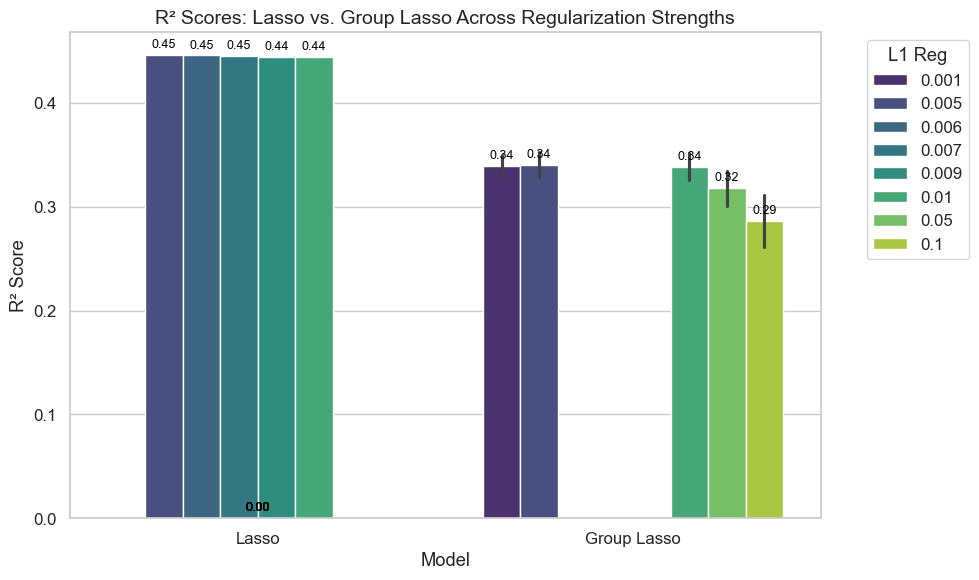

In [33]:
sns.set(style="whitegrid", font_scale=1.1)

combined_results = combined_results.sort_values(by='r2_score', ascending=False)

palette = sns.color_palette("viridis", as_cmap=False, n_colors=combined_results['l1_reg'].nunique())

# create the barplot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=combined_results,
    x='model',
    y='r2_score',
    hue='l1_reg',
    palette=palette,
    dodge=True
)

for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 3),
                     textcoords='offset points')

plt.title('R² Scores: Lasso vs. Group Lasso Across Regularization Strengths', fontsize=14)
plt.ylabel('R² Score')
plt.xlabel('Model')
plt.legend(title='L1 Reg', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()